In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run init.py

Setting up variables & DB connection for experiment:

*******************
_exp3
*******************

Snorkel session connected to:  postgres:///snorkel_exp3


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
import seaborn as sns
from snorkel.annotations import save_marginals

In [4]:
from snorkel.lf_helpers import *
import pickle,glob

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [5]:
import pandas as pd
from MLutils import cohen_kappa_score, plot_marginals_histogram, neg_to_bin_labels

In [6]:
from MLutils import diversity_heatmap, merge_pickles_pred_dicts

In [7]:
# TODO move in LSTM training section

# needed to train the LSTM here
train = session.query(REGULATOR).filter(REGULATOR.split == 0).order_by(REGULATOR.id).all()
dev = session.query(REGULATOR).filter(REGULATOR.split == 1).order_by(REGULATOR.id).all()
test = session.query(REGULATOR).filter(REGULATOR.split == 2).order_by(REGULATOR.id).all()
unlab = session.query(REGULATOR).filter(REGULATOR.split == 3).order_by(REGULATOR.id).all()

In [7]:
# Determine mean sentence size per set

In [8]:
# TODO: drop v big sentences

In [9]:
# train_sentence_size =list(map(lambda x: len(x.get_parent().lemmas) ,train))
# dev_sentence_size =list(map(lambda x: len(x.get_parent().lemmas) ,dev))
# test_sentence_size =list(map(lambda x: len(x.get_parent().lemmas) ,test))
# unlab_sentence_size =list(map(lambda x: len(x.get_parent().lemmas) ,unlab))

In [10]:
# print np.mean(train_sentence_size)
# print np.mean(dev_sentence_size)
# print np.mean(test_sentence_size)
# print np.mean(unlab_sentence_size)

In [8]:
session.query(REGULATOR).filter(REGULATOR.split == 3).count()

9167L

In [12]:
# c = train[0]
# s = c.get_parent()
# s.lemmas
# # REGULATOR.get_parent().lemmas

In [13]:
# make sure unmapped cands are gone

In [9]:
from sqlalchemy import  any_,or_,and_

In [10]:
#create list of unmapped cands to drop
to_drop = []
for k in range(4):
    query = session.query(REGULATOR).filter(and_(REGULATOR.split==k,~REGULATOR.gold_labels.any()))
    print 'Adding %i candidates from split=%i in to_drop list'%(query.count(), k)
    to_drop.extend(map(lambda x: x.id,query.all()))

Adding 0 candidates from split=0 in to_drop list
Adding 0 candidates from split=1 in to_drop list
Adding 0 candidates from split=2 in to_drop list
Adding 0 candidates from split=3 in to_drop list


In [11]:
# #drop unmapped cands
# query = session.query(Candidate).filter(Candidate.id.in_(to_drop))
# print query.count()
# query.delete(synchronize_session=False)
# session.commit()

# Retrieve results and pick models

In [12]:
import glob

In [13]:
l = glob.glob(path_base_learners+"/KMeansPeaks/*.pickle")
l.sort()
l

['pickles/_exp3/base_learner_predictions/KMeansPeaks/10clusters.pickle',
 'pickles/_exp3/base_learner_predictions/KMeansPeaks/13clusters.pickle',
 'pickles/_exp3/base_learner_predictions/KMeansPeaks/15clusters.pickle',
 'pickles/_exp3/base_learner_predictions/KMeansPeaks/20clusters.pickle',
 'pickles/_exp3/base_learner_predictions/KMeansPeaks/21clusters.pickle',
 'pickles/_exp3/base_learner_predictions/KMeansPeaks/5clusters.pickle']

In [14]:
test_scores = pd.DataFrame(index=l)

In [15]:
result_dict_file = l[1]
print "Proceeding with: ",result_dict_file

Proceeding with:  pickles/_exp3/base_learner_predictions/KMeansPeaks/13clusters.pickle


In [16]:
with open(result_dict_file, 'rb') as f:
    results_dict = pickle.load(f)
print 'Loaded %i models:\n' %len(results_dict)
results_dict.keys()

Loaded 13 models:



['results_dict,trim=5,lemmas,RuS,TfIdf_,minFreq=5,_ngrams=(0, 3)_SVC_linear',
 'results_dict,trim=0,lemmas,RuS,TfIdf_,minFreq=5,_ngrams=(0, 3)_SVC_rbf_C=150',
 'results_dict,lemmas,RuS,CV_,bin_,minFreq=5,_ngrams=(0, 3)_SVC_rbf_C=75',
 'results_dict,trim=0,lemmas,RuS,CV_,bin_,minFreq=5,_ngrams=(0, 3),LSA200_LogisticRegression',
 'results_dict,ShortDepPath,lemmas,RuS,TfIdf_,minFreq=5,_ngrams=(0, 3),LSA200_LogisticRegression',
 'results_dict,trim=5,lemmas,RuS,TfIdf_,minFreq=5,_stopw=english,_ngrams=(1, 1),LSA200_SVC_linear',
 'results_dict,trim=5,lemmas,RuS,TfIdf_,minFreq=5,_ngrams=(0, 3)_RandomForestClassifier',
 'biLSTM_biLSTM_lr=0.001',
 'results_dict,ShortDepPath,lemmas,RuS,TfIdf_,minFreq=5,_ngrams=(0, 3),LSA200_RandomForestClassifier',
 'results_dict,lemmas,RuS,TfIdf_,minFreq=5,_stopw=english,_ngrams=(1, 1),LSA200_SVC_rbf_C=250',
 'results_dict,trim=0,lemmas,RuS,TfIdf_,minFreq=5,_stopw=english,_ngrams=(1, 1),LSA200_SVC_rbf_C=250',
 'results_dict,trim=5,lemmas,RuS,CV_,bin_,minFreq=5,_

In [17]:
selected_models = results_dict.keys()
selected_models.sort()

# Load predicted labels from classifiers

In [18]:
from MLutils import diversity_matrix, reduce_results_dict

In [19]:
from sklearn.metrics import accuracy_score, cohen_kappa_score

In [20]:
from snorkel.annotations import LabelAnnotator

In [21]:
# convert labels to -1,1....
for model in selected_models:
    results_dict[model]['label_unlab'] = dict(zip(results_dict[model]['label_unlab_prob+'].keys(),(np.array(results_dict[model]['label_unlab_prob+'].values())>=0.5)*2-1))
    results_dict[model]['label_val'] = dict(zip(results_dict[model]['label_val_prob+'].keys(),(np.array(results_dict[model]['label_val_prob+'].values())>=0.5)*2-1))
#     results_dict[model]['label_train'] = dict(zip(results_dict[model]['label_train_prob+'].keys(),(np.array(results_dict[model]['label_val_prob+'].values())>=0.5)*2-1))
    results_dict[model]['label_test'] = dict(zip(results_dict[model]['label_test_prob+'].keys(),(np.array(results_dict[model]['label_test_prob+'].values())>=0.5)*2-1))


## Dataset statistics check:
## mapped vs unmapped cands in unlab set

This section indicates that Snorkels' failure to map candidates ruins the generalization on the unlabeled set.<br \>
<br \>
The results for exp3 were the following:<br \>
<br \>
Un-Mapped candidate class imbalance (predicted) :<br \>
-1    0.860072<br \>
 1    0.139928<br \>
<br \>

Mapped candidate class imbalance (predicted)<br \>
-1    0.725946<br \>
 1    0.274054<br \> 
Mapped candidate class imbalance (actual) :<br \>
-1    0.708302<br \>
 1    0.291698<br \>
 <br \>

In [27]:
# from utils import check_class_imbalance

In [28]:
# unlab_unmapped_ids = []
# query = session.query(REGULATOR).filter(and_(REGULATOR.split==3,~REGULATOR.gold_labels.any()))
# print 'Adding %i candidates from split=%i'%(query.count(), k)
# unlab_unmapped_ids.extend(map(lambda x: x.id,query.all()))

In [29]:
# unlab_mapped_ids = []
# query = session.query(REGULATOR).filter(and_(REGULATOR.split==3,REGULATOR.gold_labels.any()))
# print 'Adding %i candidates from split=%i'%(query.count(), k)
# unlab_mapped_ids.extend(map(lambda x: x.id,query.all()))

In [30]:
# model = selected_models[-1]

In [31]:
# preds_unmapped = list(map(lambda x: results_dict[model]['label_unlab'][x] , unlab_unmapped_ids))
# check_class_imbalance(preds_unmapped)

In [32]:
# preds_mapped = list(map(lambda x: results_dict[model]['label_unlab'][x] , unlab_mapped_ids))
# check_class_imbalance(preds_mapped)

** on test set (predicted) **

In [33]:
# test_ids = []
# query = session.query(REGULATOR).filter(and_(REGULATOR.split==2,REGULATOR.gold_labels.any()))
# print 'Adding %i candidates from split=%i in to_drop list'%(query.count(), k)
# test_ids.extend(map(lambda x: x.id,query.all()))

In [34]:
# preds_test = list(map(lambda x: results_dict[model]['label_test'][x] , test_ids))
# check_class_imbalance(preds_test)

## Port results into snorkel

In [22]:
# Include the results for validation data
def signal_annotator_unlab_val(c):
    """A generator over the different (worker_id, label_id) pairs for a Tweet."""
    for model in results_dict.keys():
        try:
            yield model, results_dict[model]['label_unlab'][c.id]
            
        except:
            try:
                yield model, results_dict[model]['label_val'][c.id]
            except:
                yield model, results_dict[model]['label_test'][c.id]

labeler = LabelAnnotator(label_generator=signal_annotator_unlab_val)

### Apply labeler / load label matrix from pickle

In [23]:
#regenerate L_unlab - Takes about 1h for 12 voters (100% coverage)

%time L_unlab = labeler.apply(split=3, parallelism=6)
L_unlab

Clearing existing...
Running UDF...
CPU times: user 2min 2s, sys: 5.64 s, total: 2min 8s
Wall time: 7min 33s


<9167x13 sparse matrix of type '<type 'numpy.int64'>'
	with 119171 stored elements in Compressed Sparse Row format>

In [24]:
from MLutils import balance_candidates, sample_from_csr, majority_vote, majority_vote_score, average_vote, error_analysis

In [25]:
# load validation & test set & their labels (to compute majority votes etc)
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_dev = labeler.apply_existing(split=1, parallelism=6)

L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_test = labeler.apply_existing(split=2, parallelism=6)

Clearing existing...
Running UDF...
Clearing existing...
Running UDF...


In [26]:
# load unlabeled set labels (for exp3)
L_gold_unlab = load_gold_labels(session, annotator_name='gold', split=3)

In [27]:
L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)

### Check some label statistics

In [28]:
from MLutils import average_vote, majority_vote

** Majority voting **

In [29]:
from utils import check_class_imbalance


Predicted class imbalance by maj voting:
0    0.687248
1    0.312752
dtype: float64


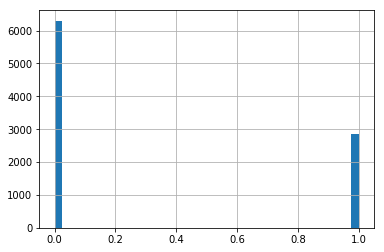

In [30]:
maj_vote_labels = majority_vote(L_unlab)
pd.Series(maj_vote_labels).hist(bins=41)
print "\nPredicted class imbalance by maj voting:"
print check_class_imbalance(maj_vote_labels)

In [31]:
print "Majority voting (val set):\n"
print majority_vote_score(L_dev, L_gold_dev)

Majority voting (val set):

(0.5667789001122334, 0.7112676056338029, 0.6308557151780138)


In [32]:
print "Majority voting (test set):\n"
print majority_vote_score(L_test, L_gold_test)

Majority voting (test set):

(0.5628691983122363, 0.6723790322580645, 0.6127698667891595)


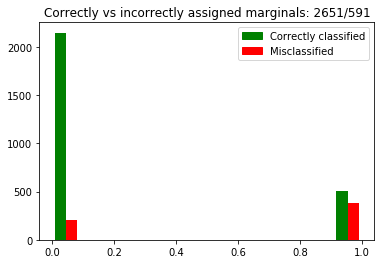

In [33]:
error_analysis(L_dev, L_gold_dev, majority_voting=True)

** Average voting **

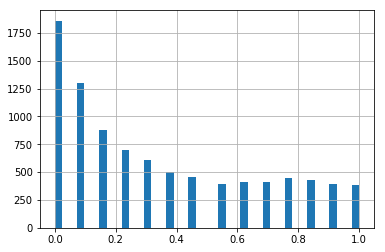

In [34]:
# get average of votes based on the preds of base classifiers
avg_vote_labels = average_vote(L_unlab)
pd.Series(avg_vote_labels).hist(bins=41)

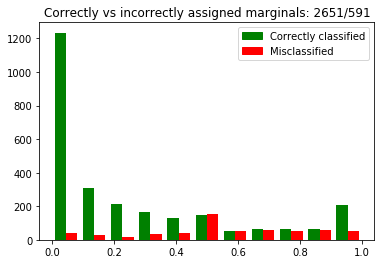

In [35]:
error_analysis(L_dev, L_gold_dev, average_voting=True)

In [37]:
# save avg vote labels as toy example for the new eval metric
with open(pkl_paths+"new_eval_metric/13models_avg_voting_labels.pkl", 'wb') as f:
    pickle.dump(avg_vote_labels, f)

# Denoising part

## Find dependencies between LFs


In [38]:
from itertools import combinations

In [39]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()

In [40]:
# Generate all possible dependencies with threshold from 0 to 0.15
all_deps = [ds.select(L_unlab, threshold=thresh) for thresh in np.array(range(0.1,15.1,2.5))/100.]
print list(map(lambda x: len(x) ,all_deps))
all_deps = list(np.unique(all_deps)) # delete duplicates for gridsearch
print list(map(lambda x: len(x) ,all_deps))

print "Maximum nr of dependencies: %i" %len(list(combinations(L_dev.col_index.values(),2)))

[78, 72, 62, 51, 39, 34, 33, 29]
[29, 33, 34, 39, 51, 62, 72, 78]
Maximum nr of dependencies: 78


# GM training

In [41]:
from snorkel.learning import RandomSearch, GenerativeModel, GridSearch

** Hyperparameter search **

In [43]:
param_ranges = { # parameters for the train function of the GenerativeModel
#     'step_size' : [10./L_unlab.shape[0],
#                   5./L_unlab.shape[0],
#                    15./L_unlab.shape[0]
#                   ],
    'decay' : [0.99],
    'epochs' : [50],
    'reg_param': [1e-1 ], #,1e-2,1e-3],
    'deps': all_deps
}

model_class_params = {  # parameters for the GenerativeModel
    'lf_propensity': [True]
}

searcher = RandomSearch(GenerativeModel, param_ranges,  L_unlab, model_class_params = model_class_params , n=24 )
searcher = GridSearch(GenerativeModel, param_ranges,  L_unlab, model_class_params = model_class_params  )


In [44]:
%%time
gen_model, run_stats = searcher.fit(L_dev, L_gold_dev, n_threads=6 )

Loading data...
Launching jobs...
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
[GenerativeModel] Model saved as <GenerativeModel_3>.
[GenerativeModel] Model saved as <GenerativeModel_1>.
[GenerativeModel] Model saved as <GenerativeModel_2>.
[GenerativeModel] Model saved as <GenerativeModel_0>.
Inferred cardinality: 2
Model 3 Done; score: 0.600487210719
[GenerativeModel] Model saved as <GenerativeModel_4>.
Inferred cardinality: 2
Model 1 Done; score: 0.60853432282
[GenerativeModel] Model saved as <GenerativeModel_5>.
Model 2 Done; score: 0.608856088561
Model 0 Done; score: 0.614241486068
Model 4 Done; score: 0.590339892665
Model 5 Done; score: 0.590476190476
[GenerativeModel] Model saved as <GenerativeModel_6>.
[GenerativeModel] Model saved as <GenerativeModel_7>.
Model 6 Done; score: 0.591532498509
Model 7 Done; score: 0.591532498509
[GenerativeModel] Model <GenerativeModel_0> loaded.
[Ge

In [45]:
run_stats['#deps'] = list(map(lambda x: len(run_stats.deps[x]), run_stats.index)) # save # deps to identify 'deps'

In [46]:
run_stats

,Model,epochs,reg_param,deps,decay,Prec.,Rec.,F-1,#deps
3,0,50,0.1,"{(1, 10, 0), (1, 3, 0), (0, 5, 0), (5, 11, 0),...",0.99,0.548066,0.698592,0.614241,29
2,2,50,0.1,"{(1, 10, 0), (1, 3, 0), (0, 5, 0), (5, 11, 0),...",0.99,0.540393,0.697183,0.608856,34
1,1,50,0.1,"{(1, 10, 0), (1, 3, 0), (0, 5, 0), (5, 11, 0),...",0.99,0.542448,0.692958,0.608534,33
0,3,50,0.1,"{(1, 10, 0), (6, 7, 0), (3, 4, 0), (1, 3, 0), ...",0.99,0.528970,0.694366,0.600487,39
6,6,50,0.1,"{(4, 7, 0), (6, 9, 0), (1, 10, 0), (6, 11, 0),...",0.99,0.512927,0.698592,0.591532,72
7,7,50,0.1,"{(4, 7, 0), (6, 9, 0), (1, 10, 0), (3, 9, 0), ...",0.99,0.512927,0.698592,0.591532,78
5,5,50,0.1,"{(4, 7, 0), (1, 10, 0), (0, 5, 0), (6, 7, 0), ...",0.99,0.511340,0.698592,0.590476,62
4,4,50,0.1,"{(1, 10, 0), (0, 5, 0), (6, 7, 0), (3, 4, 0), ...",0.99,0.511892,0.697183,0.590340,51


In [47]:
print "Generative Model params:\n"
run_stats.drop('deps', axis=1)

Generative Model params:



,Model,epochs,reg_param,decay,Prec.,Rec.,F-1,#deps
3,0,50,0.1,0.99,0.548066,0.698592,0.614241,29
2,2,50,0.1,0.99,0.540393,0.697183,0.608856,34
1,1,50,0.1,0.99,0.542448,0.692958,0.608534,33
0,3,50,0.1,0.99,0.528970,0.694366,0.600487,39
6,6,50,0.1,0.99,0.512927,0.698592,0.591532,72
7,7,50,0.1,0.99,0.512927,0.698592,0.591532,78
5,5,50,0.1,0.99,0.511340,0.698592,0.590476,62
4,4,50,0.1,0.99,0.511892,0.697183,0.590340,51


### GM performance on Validation & Test set

** Validation **

In [48]:
print "Generative Model perf (val set):\n"
_ = gen_model.error_analysis(session, L_dev, L_gold_dev)

Generative Model perf (val set):

Scores (Un-adjusted)
Pos. class accuracy: 0.699
Neg. class accuracy: 0.838
Precision            0.548
Recall               0.699
F1                   0.614
----------------------------------------
TP: 496 | FP: 409 | TN: 2123 | FN: 214



In [49]:
gen_model.weights

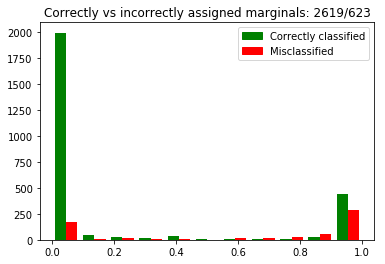

In [50]:
error_analysis(L_dev,L_gold_dev, gen_model=gen_model)

** Test **

In [51]:
print "Generative Model perf (test set):\n"
_ = gen_model.error_analysis(session, L_test, L_gold_test)

Generative Model perf (test set):

Scores (Un-adjusted)
Pos. class accuracy: 0.668
Neg. class accuracy: 0.824
Precision            0.547
Recall               0.668
F1                   0.601
----------------------------------------
TP: 1325 | FP: 1097 | TN: 5140 | FN: 659



In [52]:
gen_model.score(L_test, L_gold_test)

(0.5470685383980182, 0.6678427419354839, 0.6014525646845211)

**  (with fixed params) **

In [62]:
# %%time
# # actual training of the gen. model
# from snorkel.learning import GenerativeModel

# gen_model = GenerativeModel(lf_propensity=True, class_prior=False )

# gen_model.train(
#     L_unlab, decay=0.99, threads = 6, deps=all_deps[2], #reg_param = 1e-200, step_size = 10./L_unlab.shape[0],
#     #epochs=50
# )


In [63]:
# _ = gen_model.error_analysis(session, L_dev, L_gold_dev)

** Load a previous model **

In [64]:
# # Possibly load previously run model
# gen_model.load('GenerativeModel_8', save_dir='checkpoints/grid_search/')


In [65]:
# _ = gen_model.error_analysis(session, L_dev, L_gold_dev)

# Save marginals and proceed to LSTM training

In [54]:
unlab_marginals_gen = gen_model.marginals(L_unlab)
unlab_marginals_avg = average_vote(L_unlab)
unlab_marginals_maj = majority_vote(L_unlab)

In [ ]:
# save in db (for training in a different nb)
# save_marginals(session, L_unlab, unlab_marginals)

In [55]:
# save avg vote labels in pickle
with open(pkl_paths+"new_eval_metric/13models_GM_hyperp_labels(61%).pkl", 'wb') as f:
    pickle.dump(unlab_marginals_gen, f)

# Discriminative model learning

In [56]:
from MLutils import balance_candidates

In [57]:
from snorkel.learning import reRNN

In [58]:
#load marginals
# save avg vote labels in pickle
with open(pkl_paths+"new_eval_metric/13models_GM_hyperp_labels(61%).pkl", 'rb') as f:
    unlab_marginals_gen = pickle.load(f)

## Without GS

In [79]:
# plt.hist(unlab_marginals, bins=20)
# plt.title('Histogram of marginals with candidates undersampled before GM ')
# plt.show()

In [80]:
# ### balance cands here to shuffle 
# unlab_us, unlab_marginals_us = balance_candidates(unlab, unlab_marginals)


## with Generative model marginals 

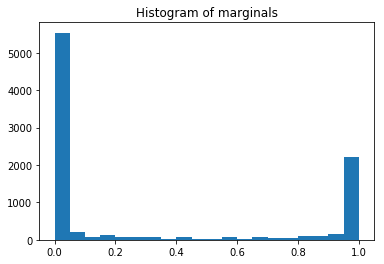

In [60]:
plot_marginals_histogram(unlab_marginals_gen, 
                         title = 'Histogram of marginals' ,
                        bins = 20)

In [82]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   20,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 256
}


** normal training **

In [104]:

lstm = reRNN(seed=1701, n_threads=6,)
lstm.train(unlab, unlab_marginals_gen , X_dev=dev, Y_dev=L_gold_dev, dev_ckpt_delay=0, **train_kwargs)

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=5606  #epochs=5  batch size=256
[reRNN] Epoch 0 (24.08s)	Average loss=0.618013	Dev F1=40.73
[reRNN] Epoch 1 (51.60s)	Average loss=0.433465	Dev F1=38.32
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (79.76s)	Average loss=0.385963	Dev F1=36.75
[reRNN] Epoch 3 (107.94s)	Average loss=0.363062	Dev F1=38.27
[reRNN] Epoch 4 (136.35s)	Average loss=0.347250	Dev F1=39.17
[reRNN] Model saved as <reRNN>
[reRNN] Training done (140.37s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-4
[reRNN] Loaded model <reRNN>


** learning curve (varying number of epochs) **

In [64]:
from MLutils import plot_learning_curve, custom_learning_curve

In [70]:
## with LSTM (Gold ---> unlab )
## with varying number of epochs (per training examples)

train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   30,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'dev_ckpt_delay': 0,
    'X_dev': dev, 
    'Y_dev': L_gold_dev,
    'verbose': False,
}

train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1 = custom_learning_curve(
    reRNN(seed=1701 ), 
    X_increm = unlab, y_increm = unlab_marginals_gen, 
    X_val = test, y_val = L_gold_test, 
    X_init= train, y_init= L_gold_train,
    X_test = test, y_test = L_gold_test, 
    fit_params = train_kwargs,
#                       splt_sizes=np.array([0.1, 0.5, 1.  ])
                     )


[0.00000000e+00 1.12058181e-04 1.71033339e-04 ... 9.99828967e-01
 9.99887942e-01 1.00000000e+00]
<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=2060  #epochs=30  batch size=64
[reRNN] Epoch 0 (10.48s)	Average loss=0.591885	Dev F1=40.14
[reRNN] Epoch 1 (25.97s)	Average loss=0.317047	Dev F1=34.91
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (41.73s)	Average loss=0.246217	Dev F1=38.44
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 3 (57.32s)	Average loss=0.212061	Dev F1=34.46
[reRNN] Epoch 4 (73.94s)	Average loss=0.182734	Dev F1=33.88
[reRNN] Epoch 5 (92.37s)	Average loss=0.165024	Dev F1=31.19
[reRNN] Epoch 6 (110.17s)	Average loss=0.155930	Dev F1=35.79
[reRNN] Epoch 7 (128.27s)	Average loss=0.138107	Dev F1=34.40
[reRNN] Epoch 8 (145.83s)	Average loss=0.137641	Dev F1=36.12
[reRNN] Epoch 9 (163.00s)	Average loss=0.109257	Dev F1=36.86
[reRNN] Epoch 10 (175.36s)	Average loss=0.106038	Dev F1=36.39
[reRNN] Epoch 11 (191.02s)	Average loss=0.098139	Dev F1=31.63
[reRNN] Epoch 12 (206.82s)	Average loss=0.094633	Dev F1=36.28
[reRNN] Epoch 13 (222.63s)	Average loss=0.101767	Dev F1=31.64
[reRNN] Epoch 1

/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 950 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 749 has argument past max length for model:	[arg ends at index 164; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 751 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 753 has argument past max length for model:	[arg ends at index 164; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.346635865669919]
F1: [0.4258872651356994]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 935 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 700 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 721 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 730 has argument past max length for model:	[arg ends at index 160; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.346635865669919, -0.33430687244687834]
F1: [0.4258872651356994, 0.4413502109704641]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 942 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 744 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 754 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 774 has argument past max length for model:	[arg ends at index 160; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.346635865669919, -0.33430687244687834, -0.3339453317260045]
F1: [0.4258872651356994, 0.4413502109704641, 0.4315387876218737]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 777 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 782 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 786 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 136 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=4012  #epochs=30  batch size=64
[reRNN] Epoch 0 (25.78s)	Average loss=0.566213	Dev F1=37.61
[reRNN] Epoch 1 (59.57s)	Average loss=0.343842	Dev F1=44.07
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (94.21s)	Average loss=0.263547	Dev F1=42.54
[reRNN] Epoch 3 (127.42s)	Average loss=0.216713	Dev F1=46.15
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 4 (160.70s)	Average loss=0.190158	Dev F1=46.37
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 5 (193.29s)	Average loss=0.157222	Dev F1=48.12
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 6 (225.87s)	Average loss=0.136360	Dev F1=49.81
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 7 (258.80s)	Average loss=0.130836	Dev F1=49.66
[reRNN] Epoch 8 (290.86s)	Average loss=0.137185	Dev F1=47.94
[reRNN] Epoch 9 (323.32s)	Average loss=0.103293	Dev F1=51.64
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 10 (355.55s)	Average loss=0.087872	Dev F1=53.25
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 11 (388.52s)	Average loss=0.0

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=5270  #epochs=30  batch size=64
[reRNN] Epoch 0 (34.78s)	Average loss=0.583663	Dev F1=34.62
[reRNN] Epoch 1 (75.97s)	Average loss=0.361865	Dev F1=47.27
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (117.56s)	Average loss=0.276539	Dev F1=46.82
[reRNN] Epoch 3 (158.79s)	Average loss=0.240521	Dev F1=49.32
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 4 (200.33s)	Average loss=0.209078	Dev F1=49.74
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 5 (242.08s)	Average loss=0.186748	Dev F1=48.19
[reRNN] Epoch 6 (283.45s)	Average loss=0.159081	Dev F1=47.94
[reRNN] Epoch 7 (324.54s)	Average loss=0.150079	Dev F1=51.10
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 8 (365.97s)	Average loss=0.127376	Dev F1=47.92
[reRNN] Epoch 9 (407.29s)	Average loss=0.116476	Dev F1=50.68
[reRNN] Epoch 10 (448.80s)	Average loss=0.106219	Dev F1=49.00
[reRNN] Epoch 11 (490.08s)	Average loss=0.105624	Dev F1=49.97
[reRNN] Epoch 12 (533.44s)	Average loss=0.095744	Dev F1=49.91
[reRNN] Epo

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=6558  #epochs=30  batch size=64
[reRNN] Epoch 0 (44.05s)	Average loss=0.543100	Dev F1=39.50
[reRNN] Epoch 1 (95.29s)	Average loss=0.353974	Dev F1=50.00
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (146.33s)	Average loss=0.277699	Dev F1=49.71
[reRNN] Epoch 3 (197.28s)	Average loss=0.236618	Dev F1=48.47
[reRNN] Epoch 4 (248.68s)	Average loss=0.212906	Dev F1=49.82
[reRNN] Epoch 5 (299.88s)	Average loss=0.197207	Dev F1=52.63
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 6 (350.28s)	Average loss=0.172880	Dev F1=49.24
[reRNN] Epoch 7 (400.88s)	Average loss=0.150978	Dev F1=52.76
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 8 (452.08s)	Average loss=0.136324	Dev F1=51.23
[reRNN] Epoch 9 (502.71s)	Average loss=0.128394	Dev F1=52.53
[reRNN] Epoch 10 (553.09s)	Average loss=0.128544	Dev F1=52.82
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 11 (606.06s)	Average loss=0.117461	Dev F1=54.08
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 12 (666.66s)	Average loss=0.

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=7804  #epochs=30  batch size=64
[reRNN] Epoch 0 (30.68s)	Average loss=0.511386	Dev F1=48.08
[reRNN] Epoch 1 (63.79s)	Average loss=0.325779	Dev F1=51.83
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (97.00s)	Average loss=0.256043	Dev F1=50.96
[reRNN] Epoch 3 (130.48s)	Average loss=0.215907	Dev F1=53.47
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 4 (163.77s)	Average loss=0.189708	Dev F1=50.76
[reRNN] Epoch 5 (197.08s)	Average loss=0.166473	Dev F1=54.23
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 6 (230.78s)	Average loss=0.147587	Dev F1=52.12
[reRNN] Epoch 7 (263.29s)	Average loss=0.136269	Dev F1=51.70
[reRNN] Epoch 8 (296.66s)	Average loss=0.130192	Dev F1=53.22
[reRNN] Epoch 9 (329.49s)	Average loss=0.119652	Dev F1=55.24
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 10 (362.79s)	Average loss=0.112082	Dev F1=53.48
[reRNN] Epoch 11 (395.30s)	Average loss=0.109659	Dev F1=51.50
[reRNN] Epoch 12 (428.04s)	Average loss=0.105358	Dev F1=53.01
[reRNN] Epoc

In [71]:
with open(pkl_paths+"learning_curves/lstm_GM_var_epochs.pickle",'wb') as f:
    pickle.dump((train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1), f)

<module 'matplotlib.pyplot' from '/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

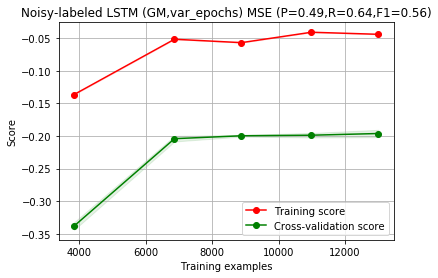

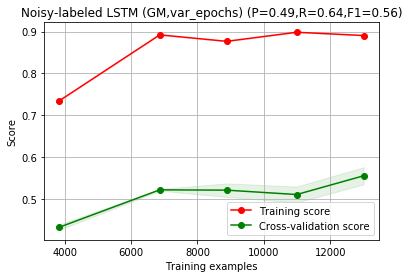

In [72]:

plot_learning_curve(train_mse,valid_mse,train_sizes, 'Noisy-labeled LSTM (GM,var_epochs) MSE (P=%.2f,R=%.2f,F1=%.2f)'%(test_prf1))

plot_learning_curve(train_f1,valid_f1,train_sizes, title='Noisy-labeled LSTM (GM,var_epochs) (P=%.2f,R=%.2f,F1=%.2f)'%(test_prf1))


** learning curve (stable number of epochs) **

In [73]:
## with LSTM (Gold ---> unlab )
## with varying number of epochs (per training examples)

from MLutils import custom_learning_curve

train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   30,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'dev_ckpt_delay': 0,
#     'X_dev': dev, 
#     'Y_dev': L_gold_dev,
    'verbose': False,
}

train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1 = custom_learning_curve(
    reRNN(seed=1701 ), 
    X_increm = unlab, y_increm = unlab_marginals_gen, 
    X_val = test, y_val = L_gold_test, 
    X_init= train, y_init= L_gold_train,
    X_test = test, y_test = L_gold_test, 
    fit_params = train_kwargs,
#                       splt_sizes=np.array([0.1, 0.5, 1.  ])
                     )


[0.00000000e+00 1.12058181e-04 1.71033339e-04 ... 9.99828967e-01
 9.99887942e-01 1.00000000e+00]
<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=2060  #epochs=30  batch size=64
[reRNN] Epoch 0 (5.66s)	Average loss=0.603640
[reRNN] Epoch 1 (11.24s)	Average loss=0.335662
[reRNN] Epoch 2 (16.75s)	Average loss=0.262586
[reRNN] Epoch 3 (22.19s)	Average loss=0.222927
[reRNN] Epoch 4 (27.44s)	Average loss=0.198891
[reRNN] Epoch 5 (32.85s)	Average loss=0.180786
[reRNN] Epoch 6 (38.18s)	Average loss=0.152718
[reRNN] Epoch 7 (43.50s)	Average loss=0.156792
[reRNN] Epoch 8 (48.80s)	Average loss=0.139922
[reRNN] Epoch 9 (54.09s)	Average loss=0.105774
[reRNN] Epoch 10 (59.52s)	Average loss=0.087976
[reRNN] Epoch 11 (64.99s)	Average loss=0.063935
[reRNN] Epoch 12 (70.23s)	Average loss=0.056500
[reRNN] Epoch 13 (75.52s)	Average loss=0.077897
[reRNN] Epoch 14 (80.83s)	Average loss=0.076000
[reRNN] Epoch 15 (86.28s)	Average loss=0.056532
[reRNN] Epoch 16 (91.67s)	Average loss=0.039775
[reRNN] Epoch 17 (96.96s)	Average loss=0.060575
[reRNN] Epoch 18 (102.42s)	Average loss=0.058844
[reRNN] Epoch 19 (107.86s)	

/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 950 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 749 has argument past max length for model:	[arg ends at index 164; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 751 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 753 has argument past max length for model:	[arg ends at index 164; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.31373159121916755]
F1: [0.4288266825491364]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 935 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 700 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 721 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 730 has argument past max length for model:	[arg ends at index 160; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.31373159121916755, -0.3155464967391754]
F1: [0.4288266825491364, 0.4336645236703682]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 942 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 744 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 754 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 774 has argument past max length for model:	[arg ends at index 160; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.31373159121916755, -0.3155464967391754, -0.31229785315869146]
F1: [0.4288266825491364, 0.4336645236703682, 0.4296828246558947]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 777 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 782 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 786 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 136 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=3964  #epochs=30  batch size=64
[reRNN] Epoch 0 (15.35s)	Average loss=0.566158
[reRNN] Epoch 1 (30.19s)	Average loss=0.342451
[reRNN] Epoch 2 (44.41s)	Average loss=0.265685
[reRNN] Epoch 3 (58.08s)	Average loss=0.224406
[reRNN] Epoch 4 (71.96s)	Average loss=0.198847
[reRNN] Epoch 5 (85.98s)	Average loss=0.169253
[reRNN] Epoch 6 (99.92s)	Average loss=0.170281
[reRNN] Epoch 7 (113.98s)	Average loss=0.151047
[reRNN] Epoch 8 (127.70s)	Average loss=0.140918
[reRNN] Epoch 9 (141.65s)	Average loss=0.113129
[reRNN] Epoch 10 (155.86s)	Average loss=0.099683
[reRNN] Epoch 11 (169.89s)	Average loss=0.089688
[reRNN] Epoch 12 (183.69s)	Average loss=0.079788
[reRNN] Epoch 13 (197.64s)	Average loss=0.078643
[reRNN] Epoch 14 (211.58s)	Average loss=0.076452
[reRNN] Epoch 15 (225.61s)	Average loss=0.083256
[reRNN] Epoch 16 (239.44s)	Average loss=0.084189
[reRNN] Epoch 17 (253.41s)	Average loss=0.089772
[reRNN] Epoch 18 (267.45s)	Average loss=0.118755
[reRNN] Epoch 1

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=5250  #epochs=30  batch size=64
[reRNN] Epoch 0 (19.09s)	Average loss=0.574463
[reRNN] Epoch 1 (37.63s)	Average loss=0.361483
[reRNN] Epoch 2 (56.29s)	Average loss=0.280589
[reRNN] Epoch 3 (74.84s)	Average loss=0.249322
[reRNN] Epoch 4 (93.49s)	Average loss=0.219070
[reRNN] Epoch 5 (112.15s)	Average loss=0.194139
[reRNN] Epoch 6 (130.72s)	Average loss=0.175095
[reRNN] Epoch 7 (149.42s)	Average loss=0.158780
[reRNN] Epoch 8 (168.16s)	Average loss=0.141685
[reRNN] Epoch 9 (186.92s)	Average loss=0.135303
[reRNN] Epoch 10 (205.64s)	Average loss=0.118658
[reRNN] Epoch 11 (224.32s)	Average loss=0.112609
[reRNN] Epoch 12 (242.54s)	Average loss=0.107311
[reRNN] Epoch 13 (261.03s)	Average loss=0.099031
[reRNN] Epoch 14 (279.92s)	Average loss=0.101064
[reRNN] Epoch 15 (298.56s)	Average loss=0.095891
[reRNN] Epoch 16 (317.38s)	Average loss=0.088514
[reRNN] Epoch 17 (335.83s)	Average loss=0.087448
[reRNN] Epoch 18 (354.49s)	Average loss=0.086521
[reRNN] Epoch

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=6552  #epochs=30  batch size=64
[reRNN] Epoch 0 (25.52s)	Average loss=0.536845
[reRNN] Epoch 1 (49.45s)	Average loss=0.351474
[reRNN] Epoch 2 (73.44s)	Average loss=0.276233
[reRNN] Epoch 3 (97.50s)	Average loss=0.218687
[reRNN] Epoch 4 (122.07s)	Average loss=0.191092
[reRNN] Epoch 5 (146.21s)	Average loss=0.161706
[reRNN] Epoch 6 (170.59s)	Average loss=0.146495
[reRNN] Epoch 7 (194.71s)	Average loss=0.133415
[reRNN] Epoch 8 (218.83s)	Average loss=0.128966
[reRNN] Epoch 9 (243.31s)	Average loss=0.126163
[reRNN] Epoch 10 (267.76s)	Average loss=0.123330
[reRNN] Epoch 11 (292.23s)	Average loss=0.116054
[reRNN] Epoch 12 (316.21s)	Average loss=0.106920
[reRNN] Epoch 13 (340.79s)	Average loss=0.111462
[reRNN] Epoch 14 (365.44s)	Average loss=0.105140
[reRNN] Epoch 15 (389.58s)	Average loss=0.097431
[reRNN] Epoch 16 (413.79s)	Average loss=0.093631
[reRNN] Epoch 17 (437.99s)	Average loss=0.106439
[reRNN] Epoch 18 (461.91s)	Average loss=0.112498
[reRNN] Epoc

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=7804  #epochs=30  batch size=64
[reRNN] Epoch 0 (28.85s)	Average loss=0.506143
[reRNN] Epoch 1 (57.37s)	Average loss=0.329114
[reRNN] Epoch 2 (85.86s)	Average loss=0.266213
[reRNN] Epoch 3 (114.04s)	Average loss=0.222939
[reRNN] Epoch 4 (142.49s)	Average loss=0.191242
[reRNN] Epoch 5 (170.57s)	Average loss=0.166105
[reRNN] Epoch 6 (199.00s)	Average loss=0.151992
[reRNN] Epoch 7 (227.87s)	Average loss=0.140212
[reRNN] Epoch 8 (256.09s)	Average loss=0.131138
[reRNN] Epoch 9 (284.84s)	Average loss=0.118516
[reRNN] Epoch 10 (312.82s)	Average loss=0.112820
[reRNN] Epoch 11 (341.34s)	Average loss=0.112662
[reRNN] Epoch 12 (369.67s)	Average loss=0.106848
[reRNN] Epoch 13 (398.69s)	Average loss=0.105537
[reRNN] Epoch 14 (427.11s)	Average loss=0.103331
[reRNN] Epoch 15 (455.63s)	Average loss=0.095760
[reRNN] Epoch 16 (484.29s)	Average loss=0.092934
[reRNN] Epoch 17 (513.06s)	Average loss=0.087514
[reRNN] Epoch 18 (541.81s)	Average loss=0.085272
[reRNN] Epo

In [74]:
with open(pkl_paths+"learning_curves/lstm_GM_30_epochs.pickle",'wb') as f:
    pickle.dump((train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1), f)

<module 'matplotlib.pyplot' from '/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

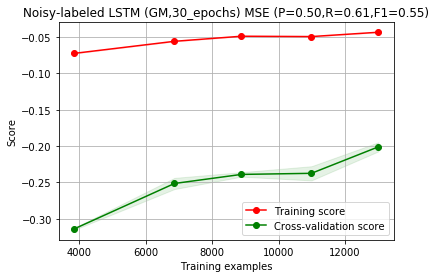

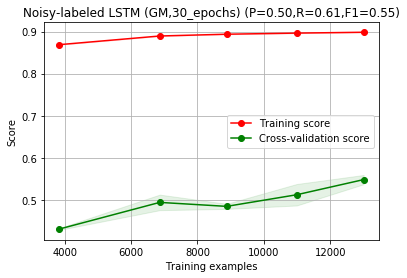

In [75]:

plot_learning_curve(train_mse,valid_mse,train_sizes, 'Noisy-labeled LSTM (GM,30_epochs) MSE (P=%.2f,R=%.2f,F1=%.2f)'%(test_prf1))

plot_learning_curve(train_f1,valid_f1,train_sizes, title='Noisy-labeled LSTM (GM,30_epochs) (P=%.2f,R=%.2f,F1=%.2f)'%(test_prf1))


** with averaging marginals **

In [ ]:
plot_marginals_histogram(unlab_marginals_avg, 
                         title = 'Histogram of marginals' ,
                        bins = 20)

In [91]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   50,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 256
}

lstm = reRNN(seed=1701, n_threads=6,)
lstm.train(unlab, unlab_marginals_avg , X_dev=dev, Y_dev=L_gold_dev,  dev_ckpt_delay=0, **train_kwargs)

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=4710  #epochs=50  batch size=256
[reRNN] Epoch 0 (19.19s)	Average loss=0.632720	Dev F1=39.32
[reRNN] Epoch 1 (43.20s)	Average loss=0.469784	Dev F1=42.54
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (67.20s)	Average loss=0.434243	Dev F1=41.59
[reRNN] Epoch 3 (90.59s)	Average loss=0.415756	Dev F1=46.87
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 4 (114.87s)	Average loss=0.407203	Dev F1=43.99
[reRNN] Epoch 5 (138.51s)	Average loss=0.397426	Dev F1=47.35
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 6 (162.12s)	Average loss=0.390338	Dev F1=49.29
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 7 (185.14s)	Average loss=0.385463	Dev F1=48.91
[reRNN] Epoch 8 (208.80s)	Average loss=0.378498	Dev F1=48.00
[reRNN] Epoch 9 (234.31s)	Average loss=0.376280	Dev F1=50.31
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 10 (257.89s)	Average loss=0.375565	Dev F1=48.85
[reRNN] Epoch 11 (281.61s)	Average loss=0.369028	Dev F1=49.30
[reRNN] Epoch 12 (304.49s)	Average loss=0.3

In [114]:
tp, fp, tn, fn = lstm.error_analysis(session, dev, L_gold_dev, batch_size = 1024)

In [116]:
tp, fp, tn, fn = lstm.error_analysis(session, test, L_gold_test, batch_size = 1024)

** Learning curves **

** learning curve (varying number of epochs) **

In [64]:
from MLutils import plot_learning_curve, custom_learning_curve

In [76]:
## with LSTM (Gold ---> unlab )
## with varying number of epochs (per training examples)

train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   30,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'dev_ckpt_delay': 0,
    'X_dev': dev, 
    'Y_dev': L_gold_dev,
    'verbose': False,
}

train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1 = custom_learning_curve(
    reRNN(seed=1701 ), 
    X_increm = unlab, y_increm = unlab_marginals_avg, 
    X_val = test, y_val = L_gold_test, 
    X_init= train, y_init= L_gold_train,
    X_test = test, y_test = L_gold_test, 
    fit_params = train_kwargs,
#                       splt_sizes=np.array([0.1, 0.5, 1.  ])
                     )


[0.00000000e+00 1.11022302e-16 7.69230769e-02 1.53846154e-01
 2.30769231e-01 3.07692308e-01 3.07692308e-01 3.84615385e-01
 4.61538462e-01 5.38461538e-01 6.15384615e-01 6.92307692e-01
 7.69230769e-01 8.46153846e-01 9.23076923e-01 1.00000000e+00
 1.00000000e+00]
<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=2064  #epochs=30  batch size=64
[reRNN] Epoch 0 (5.36s)	Average loss=0.587696	Dev F1=48.52
[reRNN] Epoch 1 (13.34s)	Average loss=0.357933	Dev F1=39.75
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (21.43s)	Average loss=0.266283	Dev F1=38.39
[reRNN] Epoch 3 (29.50s)	Average loss=0.217498	Dev F1=36.65
[reRNN] Epoch 4 (37.49s)	Average loss=0.201504	Dev F1=38.78
[reRNN] Epoch 5 (45.63s)	Average loss=0.175957	Dev F1=36.16
[reRNN] Epoch 6 (53.60s)	Average loss=0.148912	Dev F1=37.86
[reRNN] Epoch 7 (61.60s)	Average loss=0.127303	Dev F1=42.07
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 8 (69.76s)	Average loss=0.113288	Dev F1=35.90
[reRNN] Epoch 9 (77.77s)	Average loss=0.100284	Dev F1=38.11
[reRNN] Epoch 10 (85.67s)	Average loss=0.102485	Dev F1=31.97
[reRNN] Epoch 11 (93.53s)	Average loss=0.093497	Dev F1=39.15
[reRNN] Epoch 12 (101.57s)	Average loss=0.073585	Dev F1=39.41
[reRNN] Epoch 13 (109.74s)	Average loss=0.068495	Dev F1=39.19
[reRNN] Epoch 14 (117.

/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 950 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 749 has argument past max length for model:	[arg ends at index 164; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 751 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 753 has argument past max length for model:	[arg ends at index 164; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.2763937943046963]
F1: [0.37081161578555466]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 935 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 700 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 721 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 730 has argument past max length for model:	[arg ends at index 160; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.2763937943046963, -0.2664217187404996]
F1: [0.37081161578555466, 0.4038039502560351]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 942 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 744 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 754 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 774 has argument past max length for model:	[arg ends at index 160; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.2763937943046963, -0.2664217187404996, -0.26763203674144237]
F1: [0.37081161578555466, 0.4038039502560351, 0.3910112359550562]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 777 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 782 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 786 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 136 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=3922  #epochs=30  batch size=64
[reRNN] Epoch 0 (14.35s)	Average loss=0.569468	Dev F1=51.13
[reRNN] Epoch 1 (31.94s)	Average loss=0.409951	Dev F1=47.92
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (49.71s)	Average loss=0.351254	Dev F1=42.06
[reRNN] Epoch 3 (67.03s)	Average loss=0.317681	Dev F1=49.12
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 4 (84.86s)	Average loss=0.299680	Dev F1=52.24
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 5 (102.57s)	Average loss=0.284019	Dev F1=49.94
[reRNN] Epoch 6 (120.11s)	Average loss=0.264809	Dev F1=51.51
[reRNN] Epoch 7 (137.47s)	Average loss=0.253584	Dev F1=47.22
[reRNN] Epoch 8 (154.89s)	Average loss=0.248263	Dev F1=50.66
[reRNN] Epoch 9 (172.62s)	Average loss=0.237752	Dev F1=48.86
[reRNN] Epoch 10 (190.34s)	Average loss=0.231630	Dev F1=49.00
[reRNN] Epoch 11 (207.83s)	Average loss=0.236046	Dev F1=46.69
[reRNN] Epoch 12 (225.53s)	Average loss=0.230839	Dev F1=49.90
[reRNN] Epoch 13 (243.07s)	Average loss=0.229

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=5150  #epochs=30  batch size=64
[reRNN] Epoch 0 (18.96s)	Average loss=0.574138	Dev F1=54.15
[reRNN] Epoch 1 (40.90s)	Average loss=0.425758	Dev F1=49.59
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (63.27s)	Average loss=0.383022	Dev F1=52.53
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 3 (85.59s)	Average loss=0.362290	Dev F1=48.70
[reRNN] Epoch 4 (107.35s)	Average loss=0.336402	Dev F1=53.89
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 5 (129.85s)	Average loss=0.323702	Dev F1=52.46
[reRNN] Epoch 6 (151.92s)	Average loss=0.305240	Dev F1=55.00
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 7 (174.09s)	Average loss=0.290731	Dev F1=53.94
[reRNN] Epoch 8 (196.33s)	Average loss=0.287749	Dev F1=53.51
[reRNN] Epoch 9 (219.97s)	Average loss=0.283965	Dev F1=54.42
[reRNN] Epoch 10 (242.26s)	Average loss=0.274715	Dev F1=52.53
[reRNN] Epoch 11 (265.52s)	Average loss=0.263704	Dev F1=55.96
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 12 (288.35s)	Average loss=0.26

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=6512  #epochs=30  batch size=64
[reRNN] Epoch 0 (24.22s)	Average loss=0.553147	Dev F1=47.08
[reRNN] Epoch 1 (52.27s)	Average loss=0.428777	Dev F1=50.91
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (80.41s)	Average loss=0.385219	Dev F1=54.10
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 3 (109.06s)	Average loss=0.357841	Dev F1=55.15
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 4 (137.78s)	Average loss=0.338895	Dev F1=54.21
[reRNN] Epoch 5 (166.45s)	Average loss=0.327103	Dev F1=53.62
[reRNN] Epoch 6 (194.49s)	Average loss=0.315873	Dev F1=52.96
[reRNN] Epoch 7 (223.14s)	Average loss=0.304909	Dev F1=54.99
[reRNN] Epoch 8 (251.03s)	Average loss=0.297183	Dev F1=54.13
[reRNN] Epoch 9 (279.81s)	Average loss=0.292275	Dev F1=55.22
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 10 (307.71s)	Average loss=0.284912	Dev F1=55.28
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 11 (335.98s)	Average loss=0.282557	Dev F1=54.30
[reRNN] Epoch 12 (364.06s)	Average loss=0.2

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=7792  #epochs=30  batch size=64
[reRNN] Epoch 0 (29.88s)	Average loss=0.547273	Dev F1=46.95
[reRNN] Epoch 1 (63.27s)	Average loss=0.435034	Dev F1=54.61
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (96.67s)	Average loss=0.391940	Dev F1=56.27
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 3 (129.96s)	Average loss=0.363192	Dev F1=56.51
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 4 (163.55s)	Average loss=0.343990	Dev F1=56.59
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 5 (196.99s)	Average loss=0.331430	Dev F1=56.06
[reRNN] Epoch 6 (230.50s)	Average loss=0.320905	Dev F1=56.76
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 7 (264.38s)	Average loss=0.327177	Dev F1=57.24
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 8 (297.95s)	Average loss=0.333118	Dev F1=55.01
[reRNN] Epoch 9 (331.24s)	Average loss=0.326953	Dev F1=55.19
[reRNN] Epoch 10 (364.60s)	Average loss=0.319593	Dev F1=53.66
[reRNN] Epoch 11 (397.87s)	Average loss=0.311678	Dev F1=55.91
[reRNN] Epoc

In [77]:
with open(pkl_paths+"learning_curves/lstm_AvgLbls_var_epochs.pickle",'wb') as f:
    pickle.dump((train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1), f)

<module 'matplotlib.pyplot' from '/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

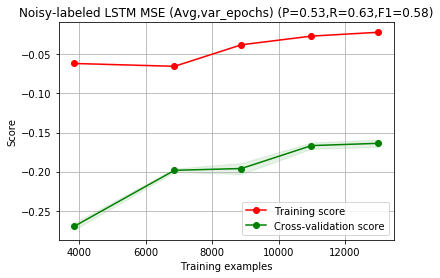

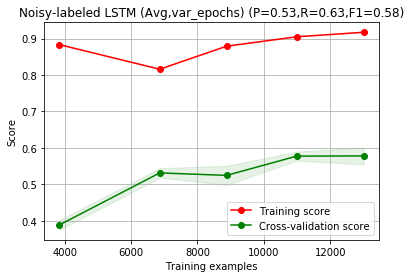

In [78]:

plot_learning_curve(train_mse,valid_mse,train_sizes, 'Noisy-labeled LSTM MSE (Avg,var_epochs) (P=%.2f,R=%.2f,F1=%.2f)'%(test_prf1))

plot_learning_curve(train_f1,valid_f1,train_sizes, title='Noisy-labeled LSTM (Avg,var_epochs) (P=%.2f,R=%.2f,F1=%.2f)'%(test_prf1))


** learning curve (stable number of epochs) **

In [79]:
## with LSTM (Gold ---> unlab )
## with varying number of epochs (per training examples)

from MLutils import custom_learning_curve

train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   30,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'dev_ckpt_delay': 0,
#     'X_dev': dev, 
#     'Y_dev': L_gold_dev,
    'verbose': False,
}

train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1 = custom_learning_curve(
    reRNN(seed=1701 ), 
    X_increm = unlab, y_increm = unlab_marginals_avg, 
    X_val = test, y_val = L_gold_test, 
    X_init= train, y_init= L_gold_train,
    X_test = test, y_test = L_gold_test, 
    fit_params = train_kwargs,
#                       splt_sizes=np.array([0.1, 0.5, 1.  ])
                     )


[0.00000000e+00 1.11022302e-16 7.69230769e-02 1.53846154e-01
 2.30769231e-01 3.07692308e-01 3.07692308e-01 3.84615385e-01
 4.61538462e-01 5.38461538e-01 6.15384615e-01 6.92307692e-01
 7.69230769e-01 8.46153846e-01 9.23076923e-01 1.00000000e+00
 1.00000000e+00]
<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=2062  #epochs=30  batch size=64
[reRNN] Epoch 0 (5.50s)	Average loss=0.585944
[reRNN] Epoch 1 (10.67s)	Average loss=0.358400
[reRNN] Epoch 2 (16.12s)	Average loss=0.268730
[reRNN] Epoch 3 (21.67s)	Average loss=0.229886
[reRNN] Epoch 4 (27.13s)	Average loss=0.200192
[reRNN] Epoch 5 (32.49s)	Average loss=0.182312
[reRNN] Epoch 6 (37.91s)	Average loss=0.173812
[reRNN] Epoch 7 (43.36s)	Average loss=0.167843
[reRNN] Epoch 8 (48.75s)	Average loss=0.155214
[reRNN] Epoch 9 (54.04s)	Average loss=0.142196
[reRNN] Epoch 10 (59.43s)	Average loss=0.128848
[reRNN] Epoch 11 (64.89s)	Average loss=0.113051
[reRNN] Epoch 12 (70.31s)	Average loss=0.110163
[reRNN] Epoch 13 (75.80s)	Average loss=0.094763
[reRNN] Epoch 14 (81.13s)	Average loss=0.080687
[reRNN] Epoch 15 (86.53s)	Average loss=0.072832
[reRNN] Epoch 16 (91.88s)	Average loss=0.057703
[reRNN] Epoch 17 (97.20s)	Average loss=0.071479
[reRNN] Epoch 18 (102.55s)	Average loss=0.056668
[reRNN] Epoch 19 (107.95s)	

/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 950 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 749 has argument past max length for model:	[arg ends at index 164; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 751 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 753 has argument past max length for model:	[arg ends at index 164; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.3211804166831542]
F1: [0.4105716041794714]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 935 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 700 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 721 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 730 has argument past max length for model:	[arg ends at index 160; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.3211804166831542, -0.33219247651405254]
F1: [0.4105716041794714, 0.3956043956043956]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 942 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 744 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 754 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 774 has argument past max length for model:	[arg ends at index 160; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.3211804166831542, -0.33219247651405254, -0.32638051709230154]
F1: [0.4105716041794714, 0.3956043956043956, 0.3957685127566895]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 777 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 782 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 786 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 136 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=3954  #epochs=30  batch size=64
[reRNN] Epoch 0 (14.42s)	Average loss=0.575706
[reRNN] Epoch 1 (28.38s)	Average loss=0.414051
[reRNN] Epoch 2 (42.13s)	Average loss=0.353411
[reRNN] Epoch 3 (55.97s)	Average loss=0.319313
[reRNN] Epoch 4 (69.69s)	Average loss=0.297754
[reRNN] Epoch 5 (83.48s)	Average loss=0.281743
[reRNN] Epoch 6 (97.33s)	Average loss=0.264826
[reRNN] Epoch 7 (111.30s)	Average loss=0.257879
[reRNN] Epoch 8 (125.14s)	Average loss=0.248280
[reRNN] Epoch 9 (139.01s)	Average loss=0.240197
[reRNN] Epoch 10 (152.91s)	Average loss=0.235557
[reRNN] Epoch 11 (166.75s)	Average loss=0.230565
[reRNN] Epoch 12 (180.57s)	Average loss=0.221101
[reRNN] Epoch 13 (194.13s)	Average loss=0.213032
[reRNN] Epoch 14 (208.35s)	Average loss=0.206619
[reRNN] Epoch 15 (222.16s)	Average loss=0.203738
[reRNN] Epoch 16 (235.84s)	Average loss=0.200279
[reRNN] Epoch 17 (249.98s)	Average loss=0.196798
[reRNN] Epoch 18 (263.91s)	Average loss=0.194162
[reRNN] Epoch 1

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=5218  #epochs=30  batch size=64
[reRNN] Epoch 0 (19.66s)	Average loss=0.561561
[reRNN] Epoch 1 (39.63s)	Average loss=0.420435
[reRNN] Epoch 2 (58.47s)	Average loss=0.375947
[reRNN] Epoch 3 (77.73s)	Average loss=0.349158
[reRNN] Epoch 4 (97.14s)	Average loss=0.329014
[reRNN] Epoch 5 (116.12s)	Average loss=0.311516
[reRNN] Epoch 6 (135.46s)	Average loss=0.297554
[reRNN] Epoch 7 (154.74s)	Average loss=0.291595
[reRNN] Epoch 8 (174.10s)	Average loss=0.283532
[reRNN] Epoch 9 (193.56s)	Average loss=0.284094
[reRNN] Epoch 10 (213.70s)	Average loss=0.275069
[reRNN] Epoch 11 (232.92s)	Average loss=0.282451
[reRNN] Epoch 12 (252.35s)	Average loss=0.270069
[reRNN] Epoch 13 (272.11s)	Average loss=0.254986
[reRNN] Epoch 14 (291.85s)	Average loss=0.247349
[reRNN] Epoch 15 (311.39s)	Average loss=0.244660
[reRNN] Epoch 16 (330.96s)	Average loss=0.241533
[reRNN] Epoch 17 (350.77s)	Average loss=0.240667
[reRNN] Epoch 18 (370.56s)	Average loss=0.239686
[reRNN] Epoch

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=6540  #epochs=30  batch size=64
[reRNN] Epoch 0 (24.94s)	Average loss=0.555967
[reRNN] Epoch 1 (48.93s)	Average loss=0.428890
[reRNN] Epoch 2 (72.83s)	Average loss=0.387800
[reRNN] Epoch 3 (96.93s)	Average loss=0.357142
[reRNN] Epoch 4 (121.32s)	Average loss=0.337352
[reRNN] Epoch 5 (145.33s)	Average loss=0.325680
[reRNN] Epoch 6 (169.69s)	Average loss=0.313127
[reRNN] Epoch 7 (193.95s)	Average loss=0.302983
[reRNN] Epoch 8 (218.25s)	Average loss=0.303482
[reRNN] Epoch 9 (242.44s)	Average loss=0.305220
[reRNN] Epoch 10 (266.73s)	Average loss=0.291225
[reRNN] Epoch 11 (290.84s)	Average loss=0.289302
[reRNN] Epoch 12 (315.22s)	Average loss=0.286719
[reRNN] Epoch 13 (339.54s)	Average loss=0.282788
[reRNN] Epoch 14 (363.67s)	Average loss=0.303059
[reRNN] Epoch 15 (387.63s)	Average loss=0.298048
[reRNN] Epoch 16 (411.78s)	Average loss=0.290485
[reRNN] Epoch 17 (436.12s)	Average loss=0.282513
[reRNN] Epoch 18 (460.50s)	Average loss=0.276079
[reRNN] Epoc

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=7794  #epochs=30  batch size=64
[reRNN] Epoch 0 (28.68s)	Average loss=0.557057
[reRNN] Epoch 1 (56.27s)	Average loss=0.441352
[reRNN] Epoch 2 (84.40s)	Average loss=0.397319
[reRNN] Epoch 3 (112.58s)	Average loss=0.371151
[reRNN] Epoch 4 (140.68s)	Average loss=0.350525
[reRNN] Epoch 5 (168.85s)	Average loss=0.351705
[reRNN] Epoch 6 (196.91s)	Average loss=0.343760
[reRNN] Epoch 7 (225.17s)	Average loss=0.323278
[reRNN] Epoch 8 (253.39s)	Average loss=0.315596
[reRNN] Epoch 9 (281.69s)	Average loss=0.314194
[reRNN] Epoch 10 (310.05s)	Average loss=0.314457
[reRNN] Epoch 11 (338.13s)	Average loss=0.314406
[reRNN] Epoch 12 (366.33s)	Average loss=0.312327
[reRNN] Epoch 13 (394.69s)	Average loss=0.310237
[reRNN] Epoch 14 (422.72s)	Average loss=0.310328
[reRNN] Epoch 15 (450.57s)	Average loss=0.316729
[reRNN] Epoch 16 (478.26s)	Average loss=0.307699
[reRNN] Epoch 17 (506.18s)	Average loss=0.300650
[reRNN] Epoch 18 (534.48s)	Average loss=0.301646
[reRNN] Epo

In [89]:
train_sizes_us = [2062,3954,5218,6540,7794]

In [80]:
with open(pkl_paths+"learning_curves/lstm_AvgLbls_30epochs.pickle",'wb') as f:
    pickle.dump((train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1), f)

<module 'matplotlib.pyplot' from '/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

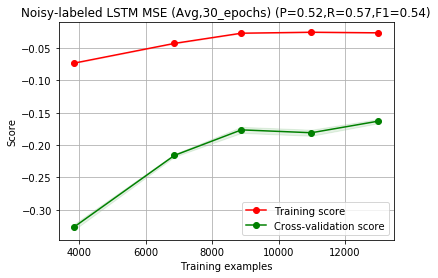

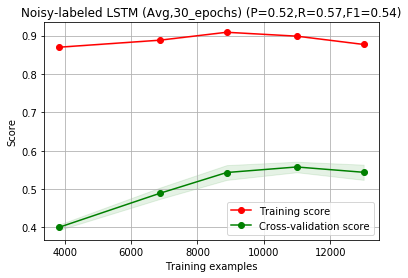

In [81]:

plot_learning_curve(train_mse,valid_mse,train_sizes, 'Noisy-labeled LSTM MSE (Avg,30_epochs) (P=%.2f,R=%.2f,F1=%.2f)'%(test_prf1))

plot_learning_curve(train_f1,valid_f1,train_sizes, title='Noisy-labeled LSTM (Avg,30_epochs) (P=%.2f,R=%.2f,F1=%.2f)'%(test_prf1))


** with majority vote labels **

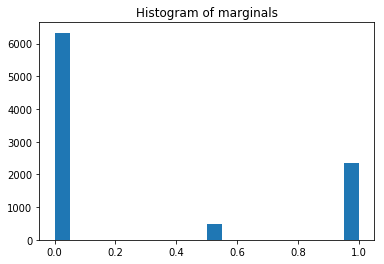

In [80]:
plot_marginals_histogram(unlab_marginals_maj, 
                         title = 'Histogram of marginals' ,
                        bins = 20)

In [81]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   20,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 256
}

lstm = reRNN(seed=1701, n_threads=6,)
lstm.train(unlab, unlab_marginals_maj , X_dev=dev, Y_dev=L_gold_dev, dev_ckpt_delay=0, **train_kwargs)

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=4710  #epochs=20  batch size=256
[reRNN] Epoch 0 (19.36s)	Average loss=0.556222	Dev F1=40.55
[reRNN] Epoch 1 (42.64s)	Average loss=0.292208	Dev F1=48.40
[reRNN] Epoch 2 (66.38s)	Average loss=0.215730	Dev F1=49.50
[reRNN] Epoch 3 (89.82s)	Average loss=0.178682	Dev F1=48.07
[reRNN] Epoch 4 (113.74s)	Average loss=0.146864	Dev F1=45.96
[reRNN] Epoch 5 (137.11s)	Average loss=0.127989	Dev F1=50.00
[reRNN] Epoch 6 (160.53s)	Average loss=0.107927	Dev F1=50.35
[reRNN] Epoch 7 (183.37s)	Average loss=0.103547	Dev F1=48.19
[reRNN] Epoch 8 (207.05s)	Average loss=0.099654	Dev F1=51.55
[reRNN] Epoch 9 (230.69s)	Average loss=0.079262	Dev F1=48.65
[reRNN] Epoch 10 (253.99s)	Average loss=0.078956	Dev F1=47.20
[reRNN] Epoch 11 (277.83s)	Average loss=0.064281	Dev F1=50.32
[reRNN] Epoch 12 (300.76s)	Average loss=0.056387	Dev F1=49.94
[reRNN] Epoch 13 (323.63s)	Average loss=0.047718	Dev F1=50.07
[reRNN] Epoch 14 (346.88s)	Average loss=0.031173	Dev F1=51.49
[reRNN] Epoc

In [105]:
tp, fp, tn, fn = lstm.error_analysis(session, dev, L_gold_dev, batch_size = 1024)

In [112]:
tp, fp, tn, fn = lstm.error_analysis(session, test, L_gold_test, batch_size = 1024)

## Learning curves

In [82]:
## with LSTM (Gold ---> unlab )
## with varying number of epochs (per training examples)

train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   30,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'dev_ckpt_delay': 0,
    'X_dev': dev, 
    'Y_dev': L_gold_dev,
    'verbose': False,
}

train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1 = custom_learning_curve(
    reRNN(seed=1701 ), 
    X_increm = unlab, y_increm = unlab_marginals_avg, 
    X_val = test, y_val = L_gold_test, 
    X_init= train, y_init= L_gold_train,
    X_test = test, y_test = L_gold_test, 
    fit_params = train_kwargs,
#                       splt_sizes=np.array([0.1, 0.5, 1.  ])
                     )


[0.00000000e+00 1.11022302e-16 7.69230769e-02 1.53846154e-01
 2.30769231e-01 3.07692308e-01 3.07692308e-01 3.84615385e-01
 4.61538462e-01 5.38461538e-01 6.15384615e-01 6.92307692e-01
 7.69230769e-01 8.46153846e-01 9.23076923e-01 1.00000000e+00
 1.00000000e+00]
<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=2062  #epochs=30  batch size=64
[reRNN] Epoch 0 (5.60s)	Average loss=0.619817	Dev F1=44.81
[reRNN] Epoch 1 (13.88s)	Average loss=0.347155	Dev F1=40.59
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (22.23s)	Average loss=0.266770	Dev F1=42.07
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 3 (30.52s)	Average loss=0.205883	Dev F1=39.79
[reRNN] Epoch 4 (38.55s)	Average loss=0.185266	Dev F1=36.30
[reRNN] Epoch 5 (46.80s)	Average loss=0.166497	Dev F1=40.08
[reRNN] Epoch 6 (54.85s)	Average loss=0.149756	Dev F1=39.30
[reRNN] Epoch 7 (63.06s)	Average loss=0.148213	Dev F1=35.34
[reRNN] Epoch 8 (71.24s)	Average loss=0.143471	Dev F1=33.96
[reRNN] Epoch 9 (79.29s)	Average loss=0.139298	Dev F1=37.28
[reRNN] Epoch 10 (87.41s)	Average loss=0.120029	Dev F1=36.91
[reRNN] Epoch 11 (95.64s)	Average loss=0.112693	Dev F1=42.76
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 12 (104.01s)	Average loss=0.098019	Dev F1=38.89
[reRNN] Epoch 13 (112.08s)	Average loss=0.100936	Dev 

/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 950 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 749 has argument past max length for model:	[arg ends at index 164; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 751 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 753 has argument past max length for model:	[arg ends at index 164; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.3328202664840597]
F1: [0.42249080399369415]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 935 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 700 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 721 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 730 has argument past max length for model:	[arg ends at index 160; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.3328202664840597, -0.32984675510822226]
F1: [0.42249080399369415, 0.43282051282051276]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 942 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 744 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 754 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 774 has argument past max length for model:	[arg ends at index 160; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.3328202664840597, -0.32984675510822226, -0.3253285207774192]
F1: [0.42249080399369415, 0.43282051282051276, 0.42283298097251587]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 777 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 782 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 786 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 136 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=3888  #epochs=30  batch size=64
[reRNN] Epoch 0 (13.37s)	Average loss=0.600135	Dev F1=46.51
[reRNN] Epoch 1 (30.81s)	Average loss=0.419046	Dev F1=48.10
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (48.33s)	Average loss=0.362991	Dev F1=44.47
[reRNN] Epoch 3 (65.58s)	Average loss=0.339106	Dev F1=45.70
[reRNN] Epoch 4 (82.95s)	Average loss=0.320008	Dev F1=45.95
[reRNN] Epoch 5 (100.04s)	Average loss=0.295430	Dev F1=47.18
[reRNN] Epoch 6 (117.58s)	Average loss=0.285426	Dev F1=46.69
[reRNN] Epoch 7 (134.99s)	Average loss=0.274149	Dev F1=48.75
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 8 (152.52s)	Average loss=0.260249	Dev F1=49.77
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (169.88s)	Average loss=0.249260	Dev F1=48.50
[reRNN] Epoch 10 (187.22s)	Average loss=0.244879	Dev F1=50.48
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 11 (204.72s)	Average loss=0.233913	Dev F1=49.70
[reRNN] Epoch 12 (221.96s)	Average loss=0.234492	Dev F1=48.23
[reRNN] Epoch 

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=5148  #epochs=30  batch size=64
[reRNN] Epoch 0 (20.05s)	Average loss=0.586880	Dev F1=46.00
[reRNN] Epoch 1 (42.71s)	Average loss=0.432748	Dev F1=49.84
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (65.74s)	Average loss=0.384198	Dev F1=48.26
[reRNN] Epoch 3 (88.43s)	Average loss=0.352087	Dev F1=50.81
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 4 (111.72s)	Average loss=0.333984	Dev F1=48.75
[reRNN] Epoch 5 (134.46s)	Average loss=0.315189	Dev F1=50.28
[reRNN] Epoch 6 (157.20s)	Average loss=0.306373	Dev F1=52.30
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 7 (180.02s)	Average loss=0.289254	Dev F1=52.90
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 8 (203.26s)	Average loss=0.280399	Dev F1=51.95
[reRNN] Epoch 9 (226.11s)	Average loss=0.289825	Dev F1=52.07
[reRNN] Epoch 10 (248.86s)	Average loss=0.278399	Dev F1=50.51
[reRNN] Epoch 11 (272.12s)	Average loss=0.262474	Dev F1=52.69
[reRNN] Epoch 12 (295.15s)	Average loss=0.257310	Dev F1=54.91
[reRNN] Model

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=6512  #epochs=30  batch size=64
[reRNN] Epoch 0 (24.76s)	Average loss=0.558222	Dev F1=39.55
[reRNN] Epoch 1 (52.98s)	Average loss=0.444965	Dev F1=50.73
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (81.20s)	Average loss=0.394633	Dev F1=54.93
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 3 (109.79s)	Average loss=0.362223	Dev F1=55.15
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 4 (138.07s)	Average loss=0.341827	Dev F1=53.28
[reRNN] Epoch 5 (165.89s)	Average loss=0.325753	Dev F1=56.02
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 6 (194.75s)	Average loss=0.313701	Dev F1=54.29
[reRNN] Epoch 7 (223.24s)	Average loss=0.311051	Dev F1=56.57
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 8 (251.55s)	Average loss=0.309414	Dev F1=57.53
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (279.77s)	Average loss=0.298661	Dev F1=57.11
[reRNN] Epoch 10 (307.90s)	Average loss=0.292147	Dev F1=54.29
[reRNN] Epoch 11 (335.94s)	Average loss=0.289346	Dev F1=56.39
[reRNN] Epoc

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=7794  #epochs=30  batch size=64
[reRNN] Epoch 0 (29.45s)	Average loss=0.555052	Dev F1=51.36
[reRNN] Epoch 1 (61.55s)	Average loss=0.440687	Dev F1=56.68
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (94.26s)	Average loss=0.396593	Dev F1=53.09
[reRNN] Epoch 3 (127.01s)	Average loss=0.369241	Dev F1=55.92
[reRNN] Epoch 4 (159.42s)	Average loss=0.355906	Dev F1=56.31
[reRNN] Epoch 5 (192.00s)	Average loss=0.336787	Dev F1=55.32
[reRNN] Epoch 6 (224.82s)	Average loss=0.330172	Dev F1=56.05
[reRNN] Epoch 7 (257.48s)	Average loss=0.334643	Dev F1=55.95
[reRNN] Epoch 8 (290.23s)	Average loss=0.320735	Dev F1=55.95
[reRNN] Epoch 9 (323.01s)	Average loss=0.310961	Dev F1=56.38
[reRNN] Epoch 10 (356.06s)	Average loss=0.305807	Dev F1=56.87
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 11 (388.56s)	Average loss=0.301361	Dev F1=57.75
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 12 (421.09s)	Average loss=0.299827	Dev F1=57.63
[reRNN] Epoch 13 (453.70s)	Average loss=0.2

In [83]:
with open(pkl_paths+"learning_curves/lstm_MVLbls_var_epochs.pickle",'wb') as f:
    pickle.dump((train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1), f)

<module 'matplotlib.pyplot' from '/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

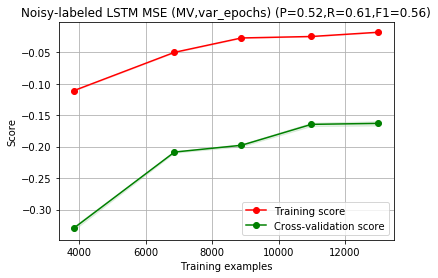

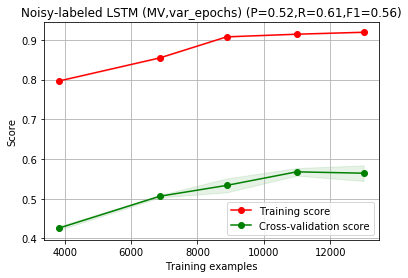

In [84]:

plot_learning_curve(train_mse,valid_mse,train_sizes, 'Noisy-labeled LSTM MSE (MV,var_epochs) (P=%.2f,R=%.2f,F1=%.2f)'%(test_prf1))

plot_learning_curve(train_f1,valid_f1,train_sizes, title='Noisy-labeled LSTM (MV,var_epochs) (P=%.2f,R=%.2f,F1=%.2f)'%(test_prf1))


** learning curve (stable number of epochs) **

In [85]:
## with LSTM (Gold ---> unlab )
## with varying number of epochs (per training examples)

from MLutils import custom_learning_curve

train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   30,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'dev_ckpt_delay': 0,
#     'X_dev': dev, 
#     'Y_dev': L_gold_dev,
    'verbose': False,
}

train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1 = custom_learning_curve(
    reRNN(seed=1701 ), 
    X_increm = unlab, y_increm = unlab_marginals_avg, 
    X_val = test, y_val = L_gold_test, 
    X_init= train, y_init= L_gold_train,
    X_test = test, y_test = L_gold_test, 
    fit_params = train_kwargs,
#                       splt_sizes=np.array([0.1, 0.5, 1.  ])
                     )


[0.00000000e+00 1.11022302e-16 7.69230769e-02 1.53846154e-01
 2.30769231e-01 3.07692308e-01 3.07692308e-01 3.84615385e-01
 4.61538462e-01 5.38461538e-01 6.15384615e-01 6.92307692e-01
 7.69230769e-01 8.46153846e-01 9.23076923e-01 1.00000000e+00
 1.00000000e+00]
<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=2060  #epochs=30  batch size=64
[reRNN] Epoch 0 (5.70s)	Average loss=0.575926
[reRNN] Epoch 1 (11.46s)	Average loss=0.337433
[reRNN] Epoch 2 (16.97s)	Average loss=0.283633
[reRNN] Epoch 3 (22.46s)	Average loss=0.238711
[reRNN] Epoch 4 (27.86s)	Average loss=0.216586
[reRNN] Epoch 5 (33.20s)	Average loss=0.182126
[reRNN] Epoch 6 (38.52s)	Average loss=0.176186
[reRNN] Epoch 7 (43.95s)	Average loss=0.171803
[reRNN] Epoch 8 (49.35s)	Average loss=0.152291
[reRNN] Epoch 9 (54.77s)	Average loss=0.129418
[reRNN] Epoch 10 (60.20s)	Average loss=0.122542
[reRNN] Epoch 11 (65.57s)	Average loss=0.104992
[reRNN] Epoch 12 (70.93s)	Average loss=0.092574
[reRNN] Epoch 13 (76.22s)	Average loss=0.090327
[reRNN] Epoch 14 (81.51s)	Average loss=0.097239
[reRNN] Epoch 15 (86.80s)	Average loss=0.085093
[reRNN] Epoch 16 (92.13s)	Average loss=0.064006
[reRNN] Epoch 17 (97.58s)	Average loss=0.041620
[reRNN] Epoch 18 (103.00s)	Average loss=0.050754
[reRNN] Epoch 19 (108.45s)	

/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 950 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 749 has argument past max length for model:	[arg ends at index 164; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 751 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 753 has argument past max length for model:	[arg ends at index 164; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.3638191294399674]
F1: [0.405616224648986]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 935 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 700 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 721 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 730 has argument past max length for model:	[arg ends at index 160; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.3638191294399674, -0.35934968315227317]
F1: [0.405616224648986, 0.42923314462171896]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 942 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 744 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 754 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 774 has argument past max length for model:	[arg ends at index 160; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.3638191294399674, -0.35934968315227317, -0.37444258591384333]
F1: [0.405616224648986, 0.42923314462171896, 0.39979231568016615]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 777 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 782 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 786 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 136 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=3940  #epochs=30  batch size=64
[reRNN] Epoch 0 (15.17s)	Average loss=0.578487
[reRNN] Epoch 1 (29.63s)	Average loss=0.417654
[reRNN] Epoch 2 (43.85s)	Average loss=0.362624
[reRNN] Epoch 3 (58.32s)	Average loss=0.326443
[reRNN] Epoch 4 (72.67s)	Average loss=0.297471
[reRNN] Epoch 5 (87.27s)	Average loss=0.282306
[reRNN] Epoch 6 (101.53s)	Average loss=0.278187
[reRNN] Epoch 7 (115.51s)	Average loss=0.267731
[reRNN] Epoch 8 (130.08s)	Average loss=0.249061
[reRNN] Epoch 9 (144.27s)	Average loss=0.242465
[reRNN] Epoch 10 (158.69s)	Average loss=0.239138
[reRNN] Epoch 11 (173.01s)	Average loss=0.237726
[reRNN] Epoch 12 (187.30s)	Average loss=0.226652
[reRNN] Epoch 13 (201.63s)	Average loss=0.214459
[reRNN] Epoch 14 (215.76s)	Average loss=0.205053
[reRNN] Epoch 15 (229.97s)	Average loss=0.211698
[reRNN] Epoch 16 (244.16s)	Average loss=0.207042
[reRNN] Epoch 17 (258.31s)	Average loss=0.199206
[reRNN] Epoch 18 (272.95s)	Average loss=0.194774
[reRNN] Epoch 

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=5214  #epochs=30  batch size=64
[reRNN] Epoch 0 (20.40s)	Average loss=0.572976
[reRNN] Epoch 1 (40.29s)	Average loss=0.434147
[reRNN] Epoch 2 (59.72s)	Average loss=0.382995
[reRNN] Epoch 3 (78.91s)	Average loss=0.352652
[reRNN] Epoch 4 (98.66s)	Average loss=0.335337
[reRNN] Epoch 5 (118.58s)	Average loss=0.321709
[reRNN] Epoch 6 (138.39s)	Average loss=0.303524
[reRNN] Epoch 7 (158.40s)	Average loss=0.293477
[reRNN] Epoch 8 (178.19s)	Average loss=0.284555
[reRNN] Epoch 9 (198.00s)	Average loss=0.283672
[reRNN] Epoch 10 (217.89s)	Average loss=0.275696
[reRNN] Epoch 11 (238.06s)	Average loss=0.267368
[reRNN] Epoch 12 (257.65s)	Average loss=0.265046
[reRNN] Epoch 13 (277.43s)	Average loss=0.257013
[reRNN] Epoch 14 (297.10s)	Average loss=0.252947
[reRNN] Epoch 15 (316.73s)	Average loss=0.247915
[reRNN] Epoch 16 (336.51s)	Average loss=0.244538
[reRNN] Epoch 17 (356.49s)	Average loss=0.241177
[reRNN] Epoch 18 (375.92s)	Average loss=0.239232
[reRNN] Epoch

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=6570  #epochs=30  batch size=64
[reRNN] Epoch 0 (24.21s)	Average loss=0.558586
[reRNN] Epoch 1 (48.43s)	Average loss=0.438967
[reRNN] Epoch 2 (72.55s)	Average loss=0.393352
[reRNN] Epoch 3 (96.38s)	Average loss=0.365948
[reRNN] Epoch 4 (120.34s)	Average loss=0.349099
[reRNN] Epoch 5 (144.42s)	Average loss=0.331533
[reRNN] Epoch 6 (168.73s)	Average loss=0.316909
[reRNN] Epoch 7 (192.94s)	Average loss=0.308702
[reRNN] Epoch 8 (217.10s)	Average loss=0.329709
[reRNN] Epoch 9 (240.97s)	Average loss=0.305320
[reRNN] Epoch 10 (264.84s)	Average loss=0.293032
[reRNN] Epoch 11 (289.11s)	Average loss=0.286534
[reRNN] Epoch 12 (312.84s)	Average loss=0.284828
[reRNN] Epoch 13 (336.78s)	Average loss=0.287633
[reRNN] Epoch 14 (360.62s)	Average loss=0.301664
[reRNN] Epoch 15 (384.60s)	Average loss=0.323040
[reRNN] Epoch 16 (408.81s)	Average loss=0.317964
[reRNN] Epoch 17 (432.51s)	Average loss=0.300934
[reRNN] Epoch 18 (456.86s)	Average loss=0.291203
[reRNN] Epoc

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=7794  #epochs=30  batch size=64
[reRNN] Epoch 0 (29.37s)	Average loss=0.556495
[reRNN] Epoch 1 (58.41s)	Average loss=0.435931
[reRNN] Epoch 2 (87.99s)	Average loss=0.392470
[reRNN] Epoch 3 (116.52s)	Average loss=0.369542
[reRNN] Epoch 4 (145.74s)	Average loss=0.352011
[reRNN] Epoch 5 (174.27s)	Average loss=0.336328
[reRNN] Epoch 6 (203.34s)	Average loss=0.325915
[reRNN] Epoch 7 (232.57s)	Average loss=0.323803
[reRNN] Epoch 8 (261.60s)	Average loss=0.317327
[reRNN] Epoch 9 (290.71s)	Average loss=0.310268
[reRNN] Epoch 10 (319.68s)	Average loss=0.339150
[reRNN] Epoch 11 (349.01s)	Average loss=0.326999
[reRNN] Epoch 12 (378.05s)	Average loss=0.315788
[reRNN] Epoch 13 (407.55s)	Average loss=0.307396
[reRNN] Epoch 14 (436.76s)	Average loss=0.300478
[reRNN] Epoch 15 (465.89s)	Average loss=0.296879
[reRNN] Epoch 16 (495.46s)	Average loss=0.294791
[reRNN] Epoch 17 (524.62s)	Average loss=0.293284
[reRNN] Epoch 18 (553.76s)	Average loss=0.292026
[reRNN] Epo

In [86]:
with open(pkl_paths+"learning_curves/lstm_MVLbls_30epochs.pickle",'wb') as f:
    pickle.dump((train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1), f)

<module 'matplotlib.pyplot' from '/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

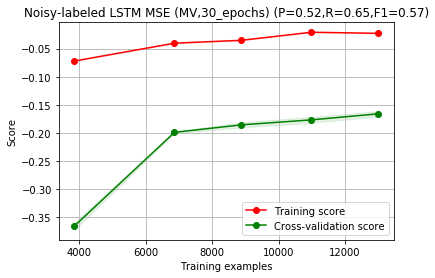

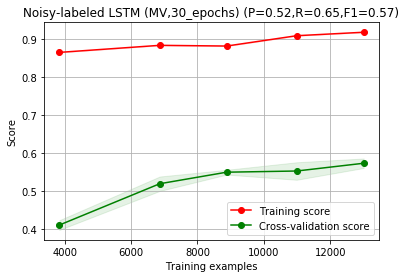

In [87]:

plot_learning_curve(train_mse,valid_mse,train_sizes, 'Noisy-labeled LSTM MSE (MV,30_epochs) (P=%.2f,R=%.2f,F1=%.2f)'%(test_prf1))

plot_learning_curve(train_f1,valid_f1,train_sizes, title='Noisy-labeled LSTM (MV,30_epochs) (P=%.2f,R=%.2f,F1=%.2f)'%(test_prf1))


# ~~  ~ ~  ~  ~ 

## With GS

In [84]:
from snorkel.annotations import load_marginals
train_labels = np.array([0 if train[x].gold_labels[0].value ==-1 else 1 for x in range(len(train))]) # load train labels to mix in LSTM
unlab_marginals = load_marginals(session, split=3)


In [85]:
train_us, train_labels_us = balance_candidates(train,train_labels)

In [86]:
train_unlab_marginals = np.append(train_labels_us, unlab_marginals_us)

NameError: name 'unlab_marginals_us' is not defined

In [ ]:
plt.hist(train_unlab_marginals, bins=20)
plt.title('Histogram of marginals (candidates undersampled before GM) + GS ')
plt.show()

In [ ]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   25,
    'dropout':    0.5,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64
}

lstm = reRNN(seed=1701, n_threads=6)
lstm.train(train_us+unlab_us, train_unlab_marginals, X_dev=dev, Y_dev=L_gold_dev, dev_ckpt_delay=0, **train_kwargs)


In [ ]:
tp, fp, tn, fn = lstm.error_analysis(session, dev, L_gold_dev)

In [ ]:
tp, fp, tn, fn = lstm.error_analysis(session, test, L_gold_test)

# ~~~~

In [60]:
print 'Inferred performance metrics by snorkel:'
gen_model.learned_lf_stats()

Inferred performance metrics by snorkel:


,Accuracy,Coverage,Precision,Recall
0,0.971729,0.8737,0.797044,0.820487
1,0.937507,0.8369,0.629160,0.805274
2,0.925276,0.8324,0.575373,0.781947
3,0.895110,0.8037,0.492881,0.737323


## Check performance on developer set

In [63]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.968743,0.8734,0.800826,0.850746
1,0.941741,0.8342,0.671815,0.763828
2,0.926562,0.8211,0.618130,0.760316
3,0.897070,0.8054,0.529931,0.738367


In [68]:
gen_model.weights.lf_accuracy

array([ 1.32927991,  0.96930229,  0.89196357,  0.71774052])

In [71]:
gen_model.score(L_dev,L_gold_dev)

(0.67838312829525482, 0.54751773049645391, 0.60596546310832033)

In [55]:
np.exp(-8*((.81+.79+.75+.73)/4)**2)

0.0087107272118617431

In [82]:
L_dev.lf_stats(session, L_gold_dev,)

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
fasttext_fasttext,0,1.0,1.0,0.486687,324,225,381,2300,0.812384
"results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear",1,1.0,1.0,0.486687,508,459,197,2066,0.796904
"RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM",2,1.0,1.0,0.486687,446,519,259,2006,0.759133
"results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier",3,1.0,1.0,0.486687,520,658,185,1867,0.739009


In [72]:
learned_stats = L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])
learned_stats

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
fasttext_fasttext,0,1.0,1.0,0.486687,324,225,381,2300,0.812384,0.968112
"results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear",1,1.0,1.0,0.486687,508,459,197,2066,0.796904,0.935136
"RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM",2,1.0,1.0,0.486687,446,519,259,2006,0.759133,0.924378
"results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier",3,1.0,1.0,0.486687,520,658,185,1867,0.739009,0.896389


### Try with priors = F1 score

In [87]:
gen_model_prior = GenerativeModel()

In [88]:
gen_model_prior.train(L_unlab, LF_acc_prior_weights=[0.5167, 0.60765, 0.5341, 0.5523 ])

Inferred cardinality: 2


In [83]:
# to pass priors as F1 score
from sklearn.metrics import f1_score

for row in learned_stats.iterrows():
    print row[0]
    tp = row[1]['TP']
    tn = row[1]['TN']
    fp = row[1]['FP']
    fn = row[1]['FN']
    pr = float(tp)/(tp+fp)
    rec = float(tp)/(tp+fn)
    f1 = (2*pr*rec)/(pr+rec)
    print f1

fasttext_fasttext
0.516746411483
results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear
0.607655502392
RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM
0.534131736527
results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier
0.552310143388


In [260]:
# # export to latex
# print learned_stats.drop(labels=['j','Coverage', 'Overlaps', 'Conflicts'], axis=1).reset_index(drop=True).to_latex()

### Put it in a log

In [157]:
gen_model_prior_log = GenerativeModel()

In [158]:
# TODO: try this from  snorkel/test/learning/test_supervised.py


LF_acc_priors = [0.5167, 0.60765, 0.5341, 0.5523 ]
cardinality = 2
LF_acc_prior_weights = [0.5 * np.log((cardinality - 1.0) * x / (1 - x)) for x in LF_acc_priors]


In [159]:
LF_acc_prior_weights

[0.033412428221050325,
 0.2187223798716636,
 0.068306034261486848,
 0.10498400583011107]

In [160]:
gen_model_prior_log.train(L_unlab, LF_acc_prior_weights=LF_acc_prior_weights)

Inferred cardinality: 2


# ~

In [163]:
gen_model.weights.lf_accuracy

array([ 0.5167 ,  0.60765,  0.5341 ,  0.5523 ])

In [99]:
np.array([0.5167, 0.60765, 0.5341, 0.5523 ])

array([ 0.5167 ,  0.60765,  0.5341 ,  0.5523 ])

In [100]:
gen_model.weights.lf_accuracy = np.array([0.5167, 0.60765, 0.5341, 0.5523 ])

In [101]:
unlab_marginals_F1 = gen_model.marginals(L_unlab)

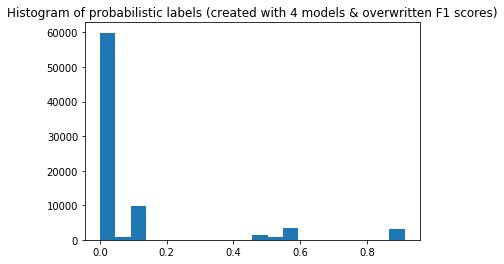

In [134]:
plt.hist(train_marginals_F1, bins=20)
plt.title('Histogram of probabilistic labels (created with %i models & overwritten F1 scores)'%n_models)
plt.show()

In [254]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
fasttext_fasttext,0,1.0,1.0,0.486687,324,225,381,2300,0.812384,0.940637
"results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear",1,1.0,1.0,0.486687,508,459,197,2066,0.796904,0.910915
"RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM",2,1.0,1.0,0.486687,446,519,259,2006,0.759133,0.922221
"results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier",3,1.0,1.0,0.486687,520,658,185,1867,0.739009,0.918230


Text(0.5,1,'Unweighted voting for 12 classifiers')

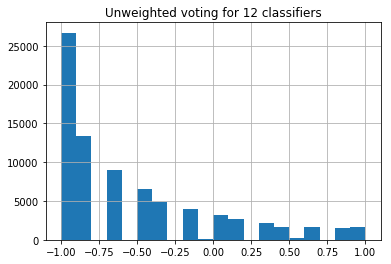

In [91]:
#this would be with unweighted voting

pd.Series(list(map(lambda x:x[0].item(),L_unlab.mean(axis=1)))).hist(bins=20)
plt.title('Unweighted voting for 12 classifiers')

In [132]:
from MLutils import majority_vote_score, majority_vote

In [137]:
majority_vote_score(L_dev, L_gold_dev)

pos/neg    705:2525 21.8%/78.2%
precision  67.84
recall     54.75
f1         60.60


In [ ]:
logp_false = e^10
logp_true = e

In [ ]:
1 / (1 + np.exp(logp_false - logp_true))

In [154]:
gen_model.weights.dep_similar

<4x4 sparse matrix of type '<type 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

## save probabilistic labels for the LSTM  -  this is the # of train. examples our LSTM will train on

In [68]:
from snorkel.annotations import save_marginals
save_marginals(session, L_unlab, unlab_marginals)

Saved 79400 marginals


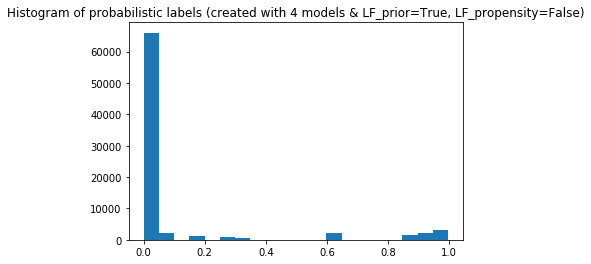

In [93]:
plt.hist(train_marginals, bins=20)
plt.title('Histogram of probabilistic labels (created with %i models & LF_prior=True, LF_propensity=False)'%n_models)
plt.show()

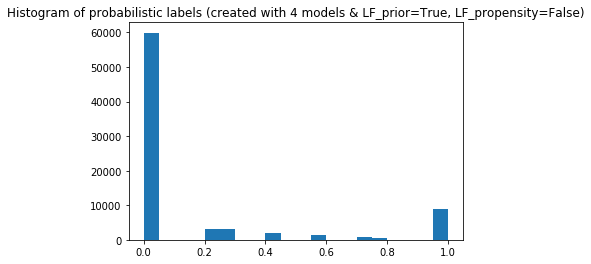

In [92]:
plt.hist(train_marginals_w_prior, bins=20)
plt.title('Histogram of probabilistic labels (created with %i models & LF_prior=True, LF_propensity=False)'%n_models)
plt.show()

# ~~ 

In [47]:
L_test = labeler.apply_existing(split=2)

Clearing existing...
Running UDF...
[========================================] 100%



In [49]:
# load from db gold labels
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_test

<13350x1 sparse matrix of type '<type 'numpy.int64'>'
	with 5781 stored elements in Compressed Sparse Row format>

In [50]:
_ = gen_model.error_analysis(session, L_test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.259
Neg. class accuracy: 0.975
Precision            0.57
Recall               0.259
F1                   0.356
----------------------------------------
TP: 388 | FP: 293 | TN: 11557 | FN: 1112



In [51]:
L_test.lf_stats(session, L_gold_test, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
dummy,0,1.000000,0.433034,0.128764,0,0,1500,4281,0.740529,0.936173
LogisticRegression,1,0.433034,0.433034,0.128764,683,563,817,3718,0.761287,0.893057
SVC_linear,2,0.433034,0.433034,0.128764,594,592,906,3689,0.740875,0.888321
SVC_rbf_C100,3,0.433034,0.433034,0.128764,606,500,894,3781,0.758865,0.893826
SVC_rbf_C500,4,0.433034,0.433034,0.128764,625,484,875,3797,0.764920,0.897841
SVC_rbf_C1000,5,0.433034,0.433034,0.128764,577,480,923,3801,0.757308,0.899282
